Let's install and import some stuff first:

In [ ]:
'''!pip install transformers
!pip install datasets
!pip install torch torchvision torchaudio
!pip install keras
!pip install tensorflow'''

In [ ]:
import transformers
import torch
import keras
from datasets import load_dataset

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from pylab import rcParams
#from matplotlib import rc
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
#from collections import defaultdict
#from textwrap import wrap
#import torch.nn.functional as F

#from torch import nn, optim
#from torch.utils.data import Dataset, DataLoader

Load Don't Patronize Me Module and Scorer (we only have to do this once)

### Loading original data (undersampled/not undersampled)

In [50]:
vals_ds_bin, trains_ds_bin = load_training_set("train_data_downsampled.csv")

Using custom data configuration default-5378d8252653fd8a
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-5378d8252653fd8a/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/5 [00:00<?, ?it/s]

Using custom data configuration default-5378d8252653fd8a
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-5378d8252653fd8a/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/5 [00:00<?, ?it/s]

'vals_ds_bin = load_dataset(\'csv\', data_files="train_set.csv", split=[\n    f\'train[{k}%:{k+20}%]\' for k in range(0, 100, 20)\n])\ntrains_ds_bin = load_dataset(\'csv\', data_files="train_set.csv", split=[\n    f\'train[:{k}%]+train[{k+20}%:]\' for k in range(0, 100, 20)\n])'

If we have trained and saved the model before, we can load it here (2nd line)

In [ ]:
metrics = {} 

for i in range(1):
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
    trainer_bin = Trainer(model=model, args=training_args, train_dataset=trains_ds_bin[i], eval_dataset=vals_ds_bin[i], compute_metrics=compute_metrics)
    trainer_bin.train()
    metrics[i] = trainer_bin.evaluate()

In [44]:
metrics_df = pd.DataFrame.from_dict(metrics).transpose()
metrics_df.describe()

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,epoch
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.0
mean,0.627468,0.692160,0.661049,0.723967,0.613904,3.0
std,0.033562,0.023670,0.069333,0.036131,0.100462,0.0
min,0.599015,0.660436,0.551440,0.673333,0.452703,3.0
25%,0.608846,0.680124,0.650350,0.705263,0.584906,3.0
50%,0.620695,0.689441,0.662295,0.732283,0.651613,3.0
75%,0.623950,0.714286,0.718266,0.740741,0.674419,3.0
max,0.684835,0.716511,0.722892,0.768212,0.705882,3.0


### Testing Model Performance on Test set

In [56]:
test = load_test_set("test_data_downsampled.csv")

Using custom data configuration default-052e446863cb49b0
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-052e446863cb49b0/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [58]:
#model = AutoModelForSequenceClassification.from_pretrained("semeval_task4/model", local_files_only=True)
#trainer = Trainer(model=model, args=training_args)

y_pred = trainer_bin.predict(test["train"])
compute_test_metrics(y_pred, 'binary')

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 199
  Batch size = 8


{'accuracy': 0.8492462311557789,
 'f1': 0.8514851485148516,
 'precision': 0.8349514563106796,
 'recall': 0.8686868686868687}

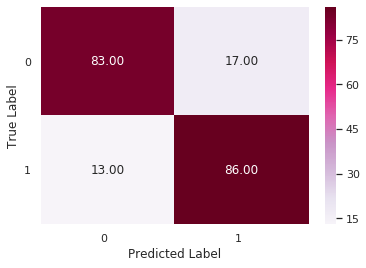

In [59]:
cm = confusion_matrix(y_pred.label_ids, y_pred.predictions.argmax(-1))
show_confusion_matrix(cm)

In [60]:
trainer.save_model('semeval_task4/model')

Saving model checkpoint to semeval_task4/model
Configuration saved in semeval_task4/model/config.json
Model weights saved in semeval_task4/model/pytorch_model.bin


### Classifying synthetic data with pre-classifier. We will only use those samples, which are classified as PCL by our classifier

In [29]:
model = AutoModelForSequenceClassification.from_pretrained("semeval_task4/model", local_files_only=True)
trainer = Trainer(model=model, args=training_args)

#test = load_dataset('csv', data_files="synthetic__data.csv")
test = load_testset("synthetic_npt_data.csv")
y_pred = trainer.predict(test["train"])

Using custom data configuration default-3388d7383deb64ac


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/jovyan/.cache/huggingface/datasets/csv/default-3388d7383deb64ac/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [30]:
compute_test_metrics(y_pred)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.8554677857319181,
 'f1': 0.4610523514933812,
 'precision': 0.5,
 'recall': 0.42773389286595903}

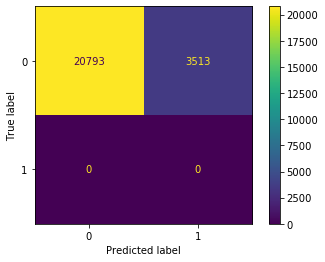

In [31]:
cm = confusion_matrix(y_pred.label_ids, y_pred.predictions.argmax(-1))
ConfusionMatrixDisplay.from_predictions(y_pred.label_ids, y_pred.predictions.argmax(-1))

In [32]:
synth = pd.read_csv("synthetic_npt_data.csv")
synth["preds"] = y_pred.predictions.argmax(-1)
synth.to_csv("synthetic_npt_data_predicted.csv")

### Saving Classifications to synthetic data file

In [78]:
synth = pd.read_csv("synthetic_data.csv")
synth["preds"] = y_pred.predictions.argmax(-1)
synth.to_csv("synthetic_data_predicted.csv")

### Using prepared synthetic_dpm dataset to train the new classifier

In [4]:
'''vals_ds_bin = load_dataset('csv', data_files="synthetic_dpm_train.csv", split=[
    f'train[{k}%:{k+20}%]' for k in range(0, 100, 20)
])
trains_ds_bin = load_dataset('csv', data_files="synthetic_dpm_train.csv", split=[
    f'train[:{k}%]+train[{k+20}%:]' for k in range(0, 100, 20)
])

vals_ds_bin = load_dataset('csv', data_files="synthetic_dpm_npt_train.csv", split=[
    f'train[{k}%:{k+20}%]' for k in range(0, 100, 20)
])
trains_ds_bin = load_dataset('csv', data_files="synthetic_dpm_npt_train.csv", split=[
    f'train[:{k}%]+train[{k+20}%:]' for k in range(0, 100, 20)
])'''

vals_ds_bin = load_dataset('csv', data_files="all_synthetic_dpm_npt_train.csv", split=[
    f'train[{k}%:{k+20}%]' for k in range(0, 100, 20)
])
trains_ds_bin = load_dataset('csv', data_files="all_synthetic_dpm_npt_train.csv", split=[
    f'train[:{k}%]+train[{k+20}%:]' for k in range(0, 100, 20)
])

Using custom data configuration default-ba7a993fd50dbdff


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/jovyan/.cache/huggingface/datasets/csv/default-ba7a993fd50dbdff/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?it/s]

Using custom data configuration default-ba7a993fd50dbdff
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-ba7a993fd50dbdff/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
#tokenizer = AutoTokenizer.from_pretrained("bert-base-german-dbmdz-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [6]:
for index, val_ds in enumerate(vals_ds_bin):
    val_ds = val_ds.remove_columns(["Unnamed: 0"])
    vals_ds_bin[index] = val_ds.map(tokenize_function, batched=True)
    
for index, train_ds in enumerate(trains_ds_bin):
    train_ds = train_ds.remove_columns(["Unnamed: 0"])
    trains_ds_bin[index] = train_ds.map(tokenize_function, batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/46 [00:00<?, ?ba/s]

  0%|          | 0/46 [00:00<?, ?ba/s]

  0%|          | 0/46 [00:00<?, ?ba/s]

  0%|          | 0/46 [00:00<?, ?ba/s]

  0%|          | 0/46 [00:00<?, ?ba/s]

In [ ]:
#metrics = {} 

for i in range(1):
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
    trainer = Trainer(model=model, args=training_args, train_dataset=trains_ds_bin[i], eval_dataset=vals_ds_bin[i], compute_metrics=compute_metrics)
    trainer.train()
    #metrics[i] = trainer.evaluate()
    
trainer_bin.save_model('semeval_task4_all_synthetics/model')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

### And evaluate performance on held-out test set

In [ ]:
#model = AutoModelForSequenceClassification.from_pretrained("semeval_task4_npt_synthetics/model", local_files_only=True)
#trainer = Trainer(model=model, args=training_args)

test = load_dataset('csv', data_files="test_set.csv")

test = test.remove_columns(["Unnamed: 0"])
test = test.map(tokenize_function, batched=True)

#redefining compute_metrics function to fit trainer.predict return

y_pred = trainer.predict(test["train"])

In [52]:
compute_test_metrics(y_pred, 'binary')

{'accuracy': 0.9178605539637058,
 'f1': 0.5656565656565655,
 'precision': 0.5685279187817259,
 'recall': 0.5628140703517588}

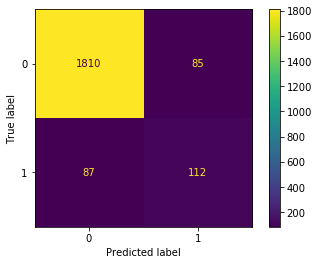

In [53]:
cm = confusion_matrix(y_pred.label_ids, y_pred.predictions.argmax(-1))
class_names = [0,1]
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [61]:
model = AutoModelForSequenceClassification.from_pretrained("semeval_task4/model", local_files_only=True)
trainer = Trainer(model=model, args=training_args)

test = load_dataset('csv', data_files="test_dataset.csv")

test = test.remove_columns(["Unnamed: 0"])
test = test.map(tokenize_function, batched=True)

#redefining compute_metrics function to fit trainer.predict returns
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

y_pred = trainer.predict(test["train"])

loading configuration file semeval_task4/model/config.json
Model config BertConfig {
  "_name_or_path": "semeval_task4/model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file semeval_task4/model/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpo

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-0bf689a0d3dfe04f/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-9a317815381ddfea.arrow
The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 3832
  Batch size = 8


In [62]:
preds = y_pred.predictions.argmax(-1)

In [63]:
res = pd.DataFrame(preds)
res.head()

,0
0,0
1,1
2,0
3,0
4,0


In [64]:
res[0].value_counts()

0    2887
1     945
Name: 0, dtype: int64

In [65]:
res.to_csv("run_post_eval/balanced_finetuned/task1.txt", header=False, index=False)

Looking pretty good. We can save the model here for later use.

In [ ]:
def labels2file(p, outf_path):
    with open(outf_path,'w') as outf:
        for pi in p:
            outf.write(','.join([str(k) for k in pi])+'\n')
            
!mkdir ref res